# Importing Dependencies

In [50]:
#import libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import seaborn as sb
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier, StackingClassifier, BaggingClassifier

# Data Description and Exploration

In [2]:
# read data 

data = pd.read_csv('premier_train_dataset.csv')
data.drop(data.columns[0],axis=1,inplace=True)

data[40:50]



#HTGS       - Home Team Goals Scored (so far in the league)
#ATGS       - Away Team Goals Scored (so far in the league)
#HTGC       - Home Team Goals Conceded (so far in the league)
#ATGC       - Away Team Goals Conceded (so far in the league)
#FTHG       - Full Time Home Goals (in the match)
#FTAG       - Full Time Away Goals (in the match)
#FTR        - Full Time Result (H- Home Win; D - Draw; A - Away Win)
#HomeTeamLP - Home Team League Position
#AwayTeamLP - Away Team League Position
#HTFormPts  - Home Team sum of points in the last 5 games
#ATFormPts  - Away Team sum of points in the last 5 games
#HTGD       - Home Team Goal Diference (so far in the league)
#ATGD       - Away Team Goal Diference (so far in the league)
#MW         - Match Week
#HTGS       - Home Team Points (so far in the league)
#ATGS       - Away Team Points (so far in the league)

,HomeTeam,AwayTeam,HTGS,ATGS,HTGC,ATGC,FTHG,FTAG,FTR,HomeTeamLP,AwayTeamLP,HTFormPts,ATFormPts,HTGD,ATGD,MW,HTP,ATP
40,Coventry,Leeds,5,5,7,3,0,0,D,14.0,3.0,6,7,0,0,5.0,7,4
41,Ipswich,Aston Villa,4,4,6,5,1,2,A,18.0,6.0,4,5,-1,-1,5.0,4,4
42,Leicester,Southampton,3,7,1,8,1,0,H,8.0,15.0,8,3,3,-2,5.0,10,2
43,Liverpool,Man City,7,7,6,9,3,2,H,4.0,18.0,7,6,1,1,5.0,7,6
44,Man United,Sunderland,11,4,3,6,3,0,H,1.0,7.0,8,4,9,-6,5.0,8,1
45,Middlesbrough,Everton,8,7,7,7,1,2,A,12.0,13.0,5,4,-2,3,5.0,2,7
46,Newcastle,Chelsea,7,7,4,7,0,0,D,11.0,5.0,9,5,5,-2,5.0,10,3
47,Derby,Charlton,9,8,10,9,2,2,D,16.0,18.0,3,4,-1,-5,5.0,3,2
48,Tottenham,West Ham,7,5,6,8,1,0,H,10.0,9.0,7,2,0,-2,5.0,7,2
49,Arsenal,Coventry,9,5,6,7,2,1,H,2.0,14.0,7,6,5,-1,5.0,11,7


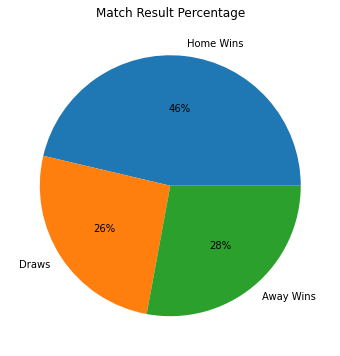

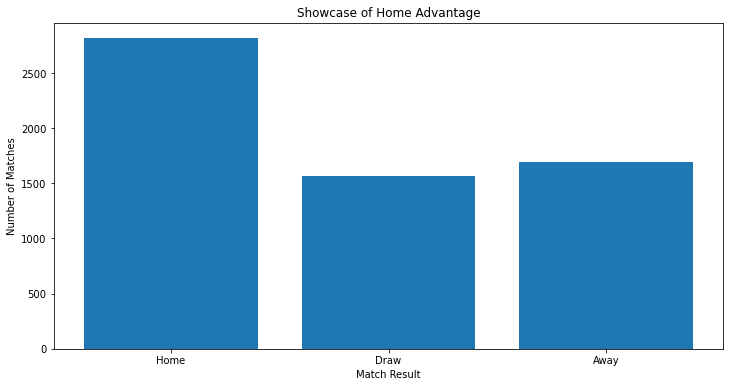

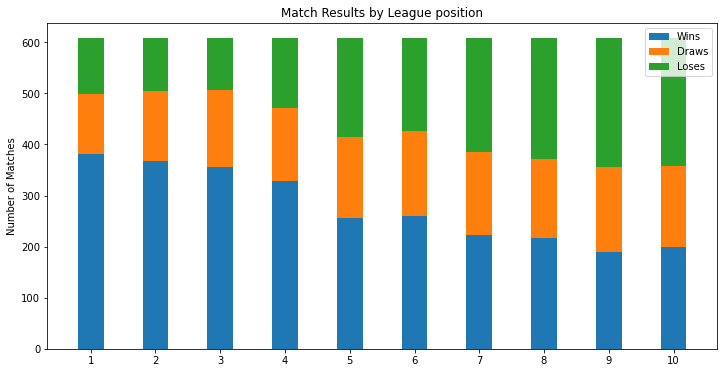

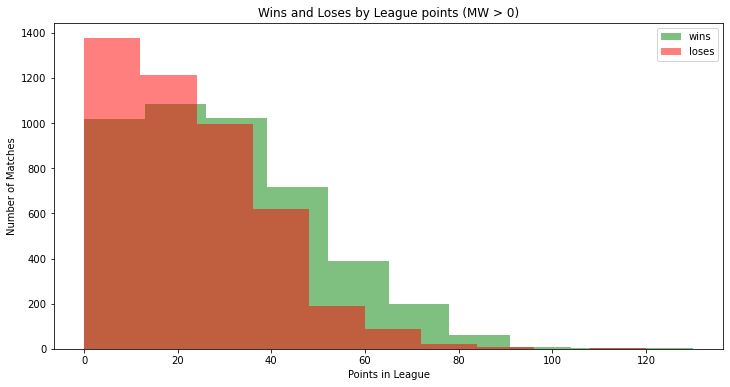

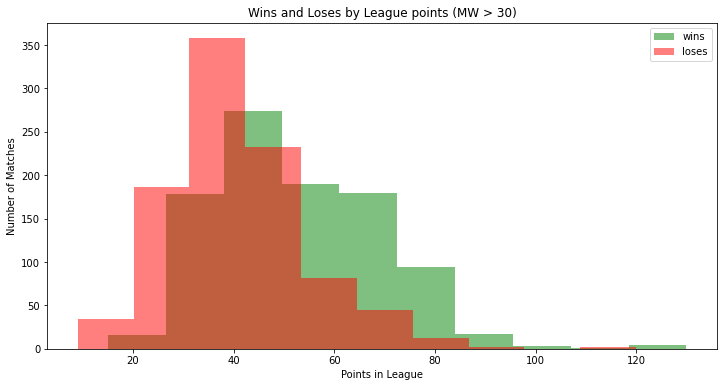

In [3]:

plt.rcParams["figure.figsize"] = (12, 6)
# Total number of matches.
n_matches = data.shape[0]

# Calculate H/D/A totals.
n_homewins = len(data[data.FTR == 'H'])
n_draws = len(data[data.FTR == 'D'])
n_awaywins = len(data[data.FTR == 'A'])

# Calculate H/D/A percentages.
home_win_rate = (float(n_homewins) / (n_matches)) * 100
draw_rate = (float(n_draws) / (n_matches)) * 100
away_win_rate = (float(n_awaywins) / (n_matches)) * 100

#Plot pie chart
pie_y = [n_homewins, n_draws, n_awaywins]
pie_labels = ["Home Wins", "Draws", "Away Wins"]
plt.pie(pie_y, labels = pie_labels, autopct='%1.0f%%')
plt.title("Match Result Percentage")
plt.show()

#Plot bar chart
bar_x = np.array(["Home", "Draw", "Away"])
bar_y = np.array([n_homewins, n_draws, n_awaywins])
plt.bar(bar_x,bar_y)
plt.xlabel("Match Result")
plt.ylabel("Number of Matches")
plt.title("Showcase of Home Advantage")
plt.show()

#Plot Bar Chart of League position W/D/L #######################################


#labels = np.flip(labels)
labels = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18']

wins = np.zeros(18)
draws = np.zeros(18)
loses = np.zeros(18)


for index, row in data.iterrows():
    if row['FTR']=='H':
        wins[int(row['HomeTeamLP'])-1]+=1
        loses[int(row['AwayTeamLP'])-1]+=1
    elif row['FTR']=='A':
        loses[int(row['HomeTeamLP'])-1]+=1
        wins[int(row['AwayTeamLP'])-1]+=1
    else:
        draws[int(row['HomeTeamLP'])-1]+=1
        draws[int(row['AwayTeamLP'])-1]+=1

# O dataset tem uma cena estranha, bué equipas na posição 18, mesmo que faça só apartir de MW 10

labels = labels[0:10]
wins = wins[0:10]
draws = draws[0:10]
loses = loses[0:10]

fig, ax = plt.subplots()
width = 0.4

ax.bar(labels, wins, width, label='Wins')
ax.bar(labels, draws, width, bottom=wins,
       label='Draws')
ax.bar(labels, loses, width, bottom=wins+draws,
       label='Loses')

ax.set_ylabel('Number of Matches')
ax.set_title('Match Results by League position')
ax.legend()

plt.show()


# Points in league vs wins
def gen_hist(mw):
    hist_wins = []
    hist_loses = []

    for index, row in data.iterrows():
        if row['MW'] > mw:
            if row['FTR']=='H':
                hist_wins.append(row['HTP'])
                hist_loses.append(row['ATP'])
            elif row['FTR']=='A':
                hist_wins.append(row['ATP'])
                hist_loses.append(row['HTP'])


    plt.hist(hist_wins, color='green', alpha=0.5, label='wins')
    plt.hist(hist_loses, color='red', alpha=0.5, label='loses')
    plt.legend(loc='upper right')
    plt.xlabel("Points in League")
    plt.ylabel("Number of Matches")
    plt.title("Wins and Loses by League points (MW > "+ str(mw)+")")
    plt.show()

gen_hist(0)
gen_hist(30)

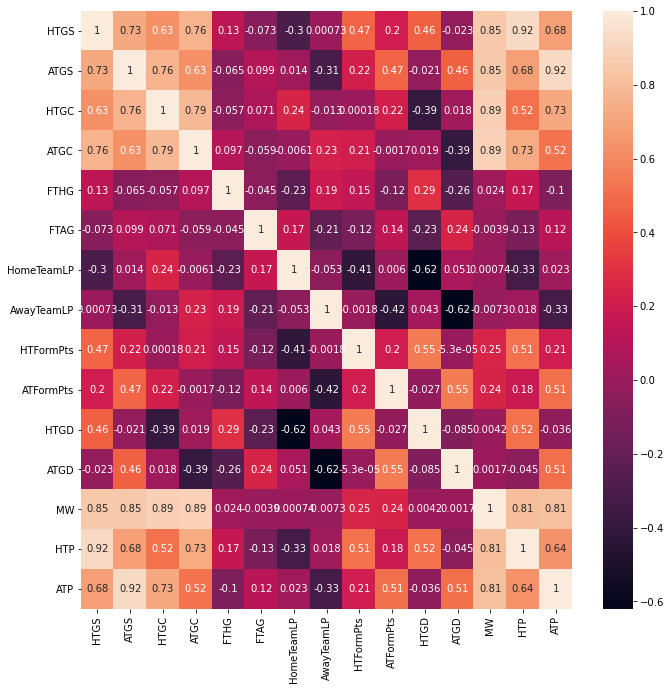

In [4]:
f, ax = plt.subplots(figsize=(11,11))
sb.heatmap(data.corr(), annot=True)
plt.show()

# Data Preparation

In [62]:
# Separate into feature set and target variable
feature_set = data.drop(['HomeTeam','AwayTeam','FTR', 'FTHG', 'FTAG'],1)
target_set = data['FTR']

cols = [['HTGS','ATGS','HTGC','ATGC','HomeTeamLP','AwayTeamLP','HTFormPts','ATFormPts','HTGD','ATGD','MW','HTP','ATP']]
for col in cols:
    feature_set[col] = scale(feature_set[col])
    
feature_set[40:50]


,HTGS,ATGS,HTGC,ATGC,HomeTeamLP,AwayTeamLP,HTFormPts,ATFormPts,HTGD,ATGD,MW,HTP,ATP
40,-1.139955,-1.147697,-1.067294,-1.309120,0.654571,-1.324887,-0.069788,0.168843,-0.019236,0.009430,-1.322286,-1.010783,-1.160716
41,-1.199019,-1.206839,-1.128677,-1.185829,1.374374,-0.785035,-0.632534,-0.399262,-0.089016,-0.060746,-1.322286,-1.171777,-1.160716
42,-1.258084,-1.029413,-1.435591,-1.000893,-0.425134,0.834522,0.492958,-0.967368,0.190106,-0.130921,-1.322286,-0.849789,-1.268505
43,-1.021826,-1.029413,-1.128677,-0.939248,-1.144937,1.374374,0.211585,-0.115210,0.050545,0.079605,-1.322286,-1.010783,-1.052927
44,-0.785568,-1.206839,-1.312825,-1.124184,-1.684789,-0.605084,0.492958,-0.683315,0.608789,-0.411623,-1.322286,-0.957119,-1.322399
45,-0.962761,-1.029413,-1.067294,-1.062539,0.294669,0.474620,-0.351161,-0.683315,-0.158797,0.219956,-1.322286,-1.279106,-0.999033
46,-1.021826,-1.029413,-1.251443,-1.062539,0.114719,-0.964986,0.774331,-0.399262,0.329667,-0.130921,-1.322286,-0.849789,-1.214610
47,-0.903697,-0.970271,-0.883146,-0.939248,1.014472,1.374374,-0.913907,-0.683315,-0.089016,-0.341447,-1.322286,-1.225442,-1.268505
48,-1.021826,-1.147697,-1.128677,-1.000893,-0.065232,-0.245183,0.211585,-1.251421,-0.019236,-0.130921,-1.322286,-1.010783,-1.268505
49,-0.903697,-1.147697,-1.128677,-1.062539,-1.504838,0.654571,0.211585,-0.115210,0.329667,-0.060746,-1.322286,-0.796125,-0.999033


# Logistic Regression

F1 score and accuracy score for training set: 0.6306 , 0.6241.
F1 score and accuracy score for test set: 0.6404 , 0.6349.
Confusion Matrix:


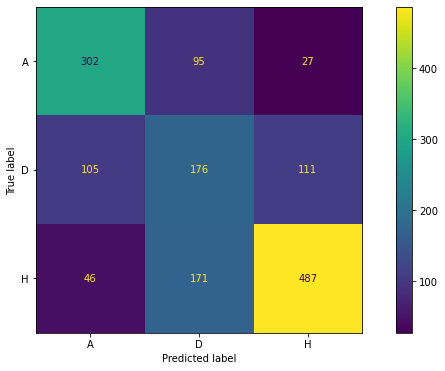

In [56]:
X_train, X_test, y_train, y_test = train_test_split(feature_set, target_set, test_size = 0.25, random_state = 23, stratify = target_set)


def train_and_test(clf, X_train, X_test, y_train, y_test):

    clf.fit(X_train, y_train)

    y_pred_train = clf.predict(X_train)
    acc_train = sum(y_train == y_pred_train) / float(len(y_pred_train))
    f1_train = f1_score(y_train, y_pred_train, average='weighted')

    print("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1_train , acc_train))

    y_pred_test = clf.predict(X_test)
    acc_test = sum(y_test == y_pred_test) / float(len(y_pred_test))
    f1_test = f1_score(y_test, y_pred_test, average='weighted')

    print("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1_test , acc_test))
    
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred_test, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()



clf_log = LogisticRegression(random_state = 24)

#print(clf_log.get_params())

parameters = { 'random_state' : 24,
               'max_iter': 1000,
               'class_weight' : 'balanced'
             }

clf_log.set_params(**parameters)

train_and_test(clf_log, X_train, X_test, y_train, y_test)

##################################################################

# Hyper-Parameter Tuning

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 1, 'class_weight': 'balanced', 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           A       0.60      0.79      0.68       424
           D       0.40      0.15      0.22       392
           H       0.70      0.81      0.75       704

    accuracy                           0.63      1520
   macro avg       0.57      0.58      0.55      1520
weighted avg       0.60      0.63      0.60      1520


F1 score and accuracy score for training set: 0.5918 , 0.6276.
F1 score and accuracy score for test set: 0.5959 , 0.6349.
Confusion Matrix:


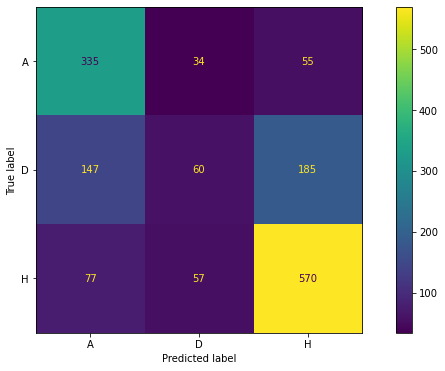

In [57]:
def parameter_tuning(X_train, X_test, y_train, y_test, model, tuned_parameters, include_grid=False):
    

    scores = ['accuracy']
    
    best_parameters = []

    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(
            model, tuned_parameters, scoring=score
        )
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        best_parameters.append(clf.best_params_)
        print(clf.best_params_)
        print()
        if include_grid:
            print("Grid scores on development set:")
            print()
            means = clf.cv_results_['mean_test_score']
            stds = clf.cv_results_['std_test_score']
            for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                print("%0.3f (+/-%0.03f) for %r"
                      % (mean, std * 2, params))
            print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()
        
    return best_parameters


tuned_parameters = [{'solver': ['lbfgs'], 'max_iter': [200, 500],
                         'C': [1, 10, 100, 1000], 'class_weight': ['balanced'],
                         'penalty': ['l2']},
                    {'solver': ['liblinear'], 'max_iter': [200, 500],
                         'C': [1, 10, 100, 1000], 'class_weight': ['balanced'],
                         'penalty': ['l1', 'l2']}]

best_parameters = parameter_tuning(X_train, X_test, y_train, y_test, LogisticRegression(), tuned_parameters)

for p in best_parameters:
    clf_log1 = LogisticRegression(random_state = 24)
    clf_log1.set_params(**p)
    train_and_test(clf_log1, X_train, X_test, y_train, y_test)

In [39]:
#Tuning for f1 score will decrease accuracy by a bit
#Tuning for accuracy will increase overall accuracy, and greatly increasy accuracy for H and A predictions but result
#in very poor D predictions


for p in best_parameters:
    clf_log1 = LogisticRegression(random_state = 24)
    clf_log1.set_params(**p)
    scores = cross_val_score(clf_log1, X_train, y_train, cv=10)
    print('Cross-Validation Accuracy Scores', scores)
    scores = pd.Series(scores)
    print('Min:',scores.min(), 'Mean:', scores.mean(), 'Max:', scores.max())

Cross-Validation Accuracy Scores [0.60964912 0.63157895 0.60964912 0.62938596 0.62719298 0.62719298
 0.58552632 0.62938596 0.63815789 0.62938596]
Min: 0.5855263157894737 Mean: 0.6217105263157896 Max: 0.6381578947368421
Cross-Validation Accuracy Scores [0.62938596 0.62061404 0.62938596 0.64473684 0.64254386 0.61622807
 0.62719298 0.62938596 0.65789474 0.63815789]
Min: 0.6162280701754386 Mean: 0.6335526315789475 Max: 0.6578947368421053


# Neural Network

{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (13, 13), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 500, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
F1 score and accuracy score for training set: 0.6658 , 0.6770.
F1 score and accuracy score for test set: 0.6569 , 0.6711.
Confusion Matrix:
Min: 0.618421052631579 Mean: 0.6484649122807019 Max: 0.6622807017543859


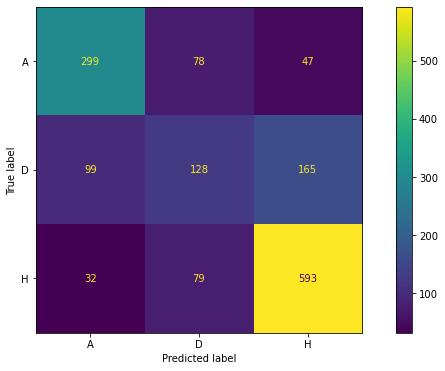

In [58]:
clf_nn = MLPClassifier(hidden_layer_sizes=(13,13), activation='relu', solver='adam', max_iter=500)

print(clf_nn.get_params())

train_and_test(clf_nn, X_train, X_test, y_train, y_test)

scores = cross_val_score(clf_nn, X_train, y_train, cv=10)
print('Min:',scores.min(), 'Mean:', scores.mean(), 'Max:', scores.max())

# Hyper-Parameter Tuning

In [ ]:
tuned_parameters = [{'solver': ['adam'], 'max_iter': [500, 750],
                     'hidden_layer_sizes': [(13,13), (13,13,13)], 'activation': ['tanh', 'relu'],
                     'alpha': [1e-3,1e-4], 'learning_rate': ['constant', 'invscaling'], 
                     'learning_rate_init': [0.001, 0.01]}]

best_parameters = parameter_tuning(X_train, X_test, y_train, y_test, MLPClassifier(), tuned_parameters)

for p in best_parameters:
    clf_nn1 = MLPClassifier()
    clf_nn1.set_params(**p)
    train_and_test(clf_nn1, X_train, X_test, y_train, y_test)

# Tuning hyper-parameters for f1_macro



/home/ruifmf/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ruifmf/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ruifmf/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ruifmf/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ruifmf/anaconda3/lib/python3.8/sit

In [14]:
for p in best_parameters:
    clf_nn1 = MLPClassifier(random_state = 24)
    clf_nn1.set_params(**p)
    scores = cross_val_score(clf_nn1, X_train, y_train, cv=15)
    print('Cross-Validation Accuracy Scores', scores)
    scores = pd.Series(scores)
    print('Min:',scores.min(), 'Mean:', scores.mean(), 'Max:', scores.max())

Cross-Validation Accuracy Scores [0.64144737 0.70394737 0.63486842 0.65789474 0.66447368 0.66447368
 0.66776316 0.61513158 0.66447368 0.69407895 0.65789474 0.65789474
 0.62828947 0.65460526 0.67763158]
Min: 0.6151315789473685 Mean: 0.6589912280701754 Max: 0.7039473684210527
Cross-Validation Accuracy Scores [0.63486842 0.69407895 0.62828947 0.64144737 0.65789474 0.63815789
 0.65789474 0.60197368 0.67434211 0.62828947 0.67763158 0.65789474
 0.67434211 0.67434211 0.65789474]
Min: 0.6019736842105263 Mean: 0.6532894736842105 Max: 0.694078947368421


# Stratified K-Fold

In [9]:
def skfold_test(X, y, clf, k):
    skf = StratifiedKFold(n_splits=k, shuffle=True)
    acc_score = []

    for train_index, test_index in skf.split(X, y):
        X_trainf, X_testf = X.iloc[train_index,:], X.iloc[test_index,:]
        y_trainf, y_testf = y[train_index], y[test_index]
        clf.fit(X_trainf, y_trainf)
        y_pred = clf.predict(X_testf)

        acc = accuracy_score(y_pred , y_testf)
        acc_score.append(acc)

    avg_acc_score = sum(acc_score)/k

    print('accuracy of each fold - {}'.format(acc_score))
    print('Avg accuracy : {}'.format(avg_acc_score))

    

optimal_params = {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (13, 13), 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'max_iter': 750, 'solver': 'adam'}
clf_nn2 = MLPClassifier(random_state = 24)
clf_nn2.set_params(**optimal_params)
print('Neural Network:')
skfold_test(feature_set, target_set, clf_nn2, 4)

optimal_params = {'C': 1, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
clf_log2 = LogisticRegression(random_state = 24)
clf_log2.set_params(**optimal_params)
print('Logistic Regression:')
skfold_test(feature_set, target_set, clf_log2, 5)

Neural Network:
accuracy of each fold - [0.6625, 0.6532894736842105, 0.6618421052631579, 0.6631578947368421]
Avg accuracy : 0.6601973684210526
Logistic Regression:
accuracy of each fold - [0.6439144736842105, 0.6274671052631579, 0.6430921052631579, 0.631578947368421, 0.647203947368421]
Avg accuracy : 0.6386513157894737


# Ensemble Voting

In [30]:
nn_params = {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (13, 13), 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'max_iter': 750, 'solver': 'adam'}
log_params = {'C': 1, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}

clf_nn3 = MLPClassifier(random_state = 24)
clf_nn3.set_params(**nn_params)

clf_svm = SVC(kernel="rbf", C=1000, gamma=0.01)

eclf = VotingClassifier(estimators=[('mlp',clf_nn3), ('mlp_kfold',clf_nn2), ('svm', clf_svm)], voting='hard')

scores = cross_val_score(estimator=eclf, X=X_train, y=y_train, cv= 10, scoring = 'accuracy')
scores = pd.Series(scores)
print('Min:',scores.min(), 'Mean:', scores.mean(), 'Max:', scores.max())

Min: 0.631578947368421 Mean: 0.6513157894736843 Max: 0.6644736842105263


F1 score and accuracy score for training set: 0.6638 , 0.6798.
F1 score and accuracy score for test set: 0.6529 , 0.6711.
Confusion Matrix:


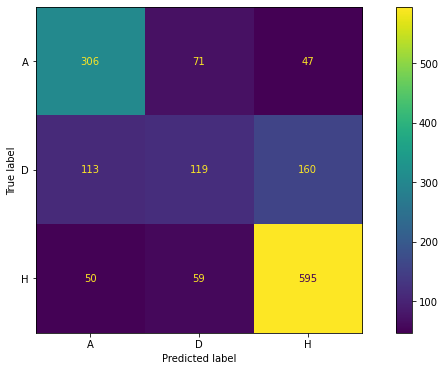

In [12]:
train_and_test(eclf, X_train, X_test, y_train, y_test)

Min: 0.6403508771929824 Mean: 0.6629385964912281 Max: 0.6885964912280702
F1 score and accuracy score for training set: 0.6930 , 0.7046.
F1 score and accuracy score for test set: 0.6611 , 0.6822.
Confusion Matrix:


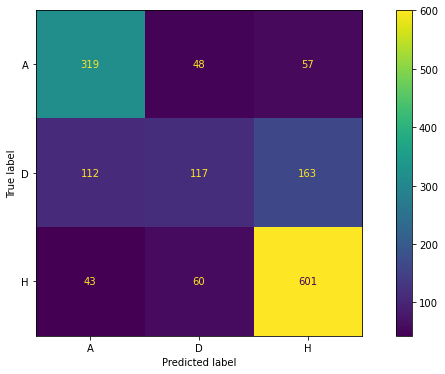

In [60]:
estimators = []

for i in range(5):
    nn_params = {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (13, 13), 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'max_iter': 1500, 'solver': 'adam'}

    clf_nn = MLPClassifier(random_state = i)
    clf_nn.set_params(**nn_params)
    #skfold_test(feature_set, target_set, clf_nn, 5)
    estimators.append(('mlp'+str(i), clf_nn))
    
    clf_svm = SVC(random_state = i, kernel="rbf", C=1000, gamma=0.01)
    #skfold_test(feature_set, target_set, clf_svm, 5)
    estimators.append(('svm'+str(i), clf_svm))
    
eclf = VotingClassifier(estimators=estimators, voting='hard')

scores = cross_val_score(estimator=eclf, X=X_train, y=y_train, cv= 10, scoring = 'accuracy')
scores = pd.Series(scores)
print('Min:',scores.min(), 'Mean:', scores.mean(), 'Max:', scores.max())

train_and_test(eclf, X_train, X_test, y_train, y_test)

Feature: 0, Score: 6.12068
Feature: 1, Score: -5.11060
Feature: 2, Score: -6.30220
Feature: 3, Score: 5.25995
Feature: 4, Score: -0.18659
Feature: 5, Score: 0.18902
Feature: 6, Score: -5.83876
Feature: 7, Score: 5.00965
Feature: 8, Score: 0.00000
Feature: 9, Score: -0.10175
Feature: 10, Score: 0.02411


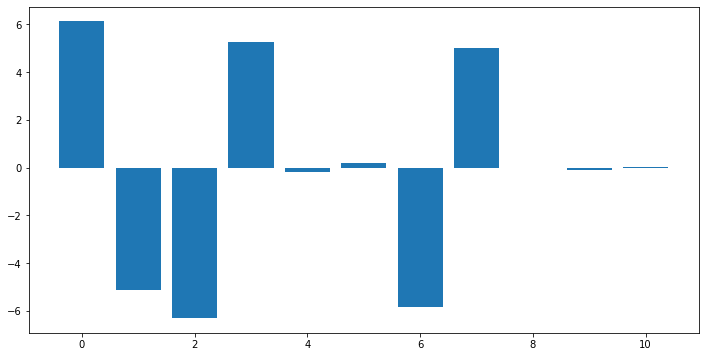

In [64]:
log_clf = LogisticRegression(C=1, class_weight='balanced', max_iter=500, penalty='l1', solver='liblinear')

log_clf.fit(X_train, y_train)

importance = log_clf.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()